<a href="https://colab.research.google.com/github/LanqingDu/UnstructuredDataAnalytics/blob/main/07_AdvancedTextAnalytics.ipynb" target="_blank">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# **Getting Started with Text Classification**



> **Instructor:** Dr. Lanqing Du  
> **Acknowledgement:** This notebook referenced to R user guide content and Machine Learning resoures.  
> **Objective:** Introduction to Classification: Logistic Regression.  
> **Instructions:** You can preview the **Table of Contents** from the side bar.

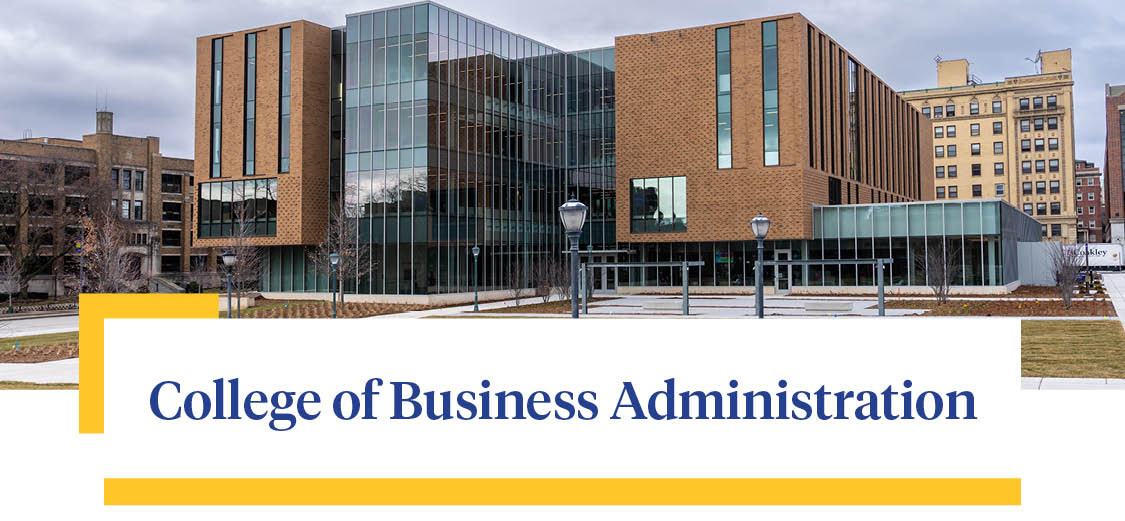
---

## [1. Intro](#intro)


Some machine learning (ML) models for supervised and unsupervised learning are discussed here. Note: general ML workflows and architectures are introduced in [03_R_Intro_BA4.ipynb](https://github.com/LanqingDu/UnstructuredDataAnalytics/blob/main/03_R_Intro_BA4.ipynb). In this notebook, we introduce additional supervised model (logistic regression, SVM, and Naive Bayes) for text analysis. Each model is used to perform a different classification tasks.


## [2. Objective](#obj)

This tutorial utilizes several datasets.

We begin our introduction to classification starting from train test dat splitting. The following tasks will guide our workflow:

1. **Library Setup**
Install and load all required packages for data access, text processing, train test split, and logistic regression model.

2. **Data Exploration**
Import the dataset and review its structure, variables, and any predefined helper functions.

3. **Text Preprocessing**
Split into training and testing data. Define the response variable and independent variables. Clean and transform the text into a structured format (e.g., data frame or tibble) for classification.

4. **Training a Model**
In this step, we train a classification model that uses the independent variables as predictors to classify or estimate the categories of the response variable.

5. **Testing a Model**
Model evaluation is conducted on the testing data. Several metrics are used to evaluate the model, such as the Receiver Operating Characteristic (ROC) curve and the corresponding Area Under the Curve (AUC), which measure the model’s discriminative ability.








## [3. Introduction to Logistic Classification](#pract1)

This section utilizes several datasets available through the [gutenbergr package](https://cran.r-project.org/web/packages/gutenbergr/index.html). In this logistic regression classification task, we aim to use textual features to predict the author of each document.

**Logistic Classification General Workflow:**

1. Load required packages: tm (for text processing), caret (for data splitting and evaluation), glmnet (for logistic regression)

2. Import dataset.

3. Create a text corpus. Logistic Regression can’t process raw text directly — it requires numeric input features.

4. Preprocess the text.
Convert text to lowercase, remove punctuation, numbers, stop words, and strip extra whitespace for consistency.

5. Create a Document-Term Matrix (DTM) or another suitable sparse matrix format.

6. Add target labels.
Append the class label column and convert it to a factor.

7. Split into training and testing sets.
Use createDataPartition() to divide the data (e.g., 80% training, 20% testing).

8. Model training, testing, evaluation.
Train the logistic regression model using glm(label ~ ., family = "binomial"), predict on the test set, and evaluate using confusionMatrix() or ROC–AUC metrics.

### 3.1. Load the library and the data

In [1]:
# ========================================================
# Step 1-1: Download and include the data library
# ========================================================

install.packages("gutenbergr")
library(gutenbergr)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘triebeard’, ‘readMDTable’, ‘urltools’




In [2]:
 # ========================================================
# Step 1-2: Download and include the data processing library
# ========================================================

install.packages("tidyverse")
install.packages("tidytext")
install.packages("stopwords")

library(tidyverse)
library(tidytext)
library(stopwords)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘SnowballC’, ‘janeaustenr’, ‘tokenizers’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘ISOcodes’


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
# ========================================================
# Step 1-3: Load in the data (two authors)
# ========================================================


books <- gutenberg_download(gutenberg_id = c(30155, 13476),
                            meta_fields = "author",
                            "http://mirrors.xmission.com/gutenberg/") %>%
         as_tibble() %>%
         mutate(document = row_number()) %>%
         select(-gutenberg_id)

tidy_books <- books %>%
  unnest_tokens(word, text) %>% # Tokenize the text in the text column of the books tibble, breaking it into individual words
  group_by(word) %>%
  filter(n() > 10) %>%
  ungroup()


### 3.2. Train Test Split

In [4]:
# ========================================================
# Step 2: Parition the data into training and testing data
# ========================================================

install.packages("rsample") # provides functions for data splitting, resampling, and related tasks
library(rsample)

#  initial_split(data, prop = 3/4)
#   data          : The data frame or tibble to be split into training and testing subsets.
#   prop          : The proportion of the data to allocate to the training set; here, `3/4` (or 75%) of the data is used for training.
#   Returns       : An `rsplit` object containing information about the training and testing partitions.
#   Output        : Randomly divides the dataset into a training set (75%) and a testing set (25%)
#                   for model development and performance evaluation.

books_split <- books %>%
  select(document) %>%
  initial_split(prop = 3/4) # Split the dataset into 75% for training and 25% for testing.

set.seed(123)
train_data <- training(books_split) # it only returns the index for the document

test_data <- testing(books_split)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘warp’, ‘furrr’, ‘slider’




### 3.3. Training data (sparse matrix)


Now we want to transform our training data from a tidy data structure to a “sparse matrix” (these objects can be treated as though they were matrices, for example accessing particular rows and columns, but are stored in a more efficient format) to use for our classification algorithm

In [5]:
# ========================================================
# Step 3: Build the sparse matrix for the training data
# ========================================================

#  cast_sparse(row, column, value, shape = NULL)
#   row            : The column to use for the rows of the sparse matrix (e.g., `tidy_boooks`).
#   column         : The column to use for the columns of the sparse matrix (e.g., `document`).
#   value          : The column containing numeric values to fill the cells (e.g., word counts `n`, frequencies, or weights).
#   shape          : (Optional) A two-element vector specifying the number of rows and columns in the matrix;
#                    defaults to dimensions inferred from the data.
#   Returns        : A sparse matrix of class `dgCMatrix` (from the **Matrix** package) with rows and columns defined
#                    by the specified variables.
#   Output         : Produces a document-term matrix (DTM) or term-document matrix (TDM) in sparse format,
#                    efficiently representing text data where most entries are zero.


sparse_words <- tidy_books %>%
  count(document, word) %>%
  inner_join(train_data, by = "document") %>% # filter the word counts to include only the documents in the training set
  cast_sparse(document, word, n) # the cast_sparse() function to convert the filtered word counts into a sparse matrix
                                 # This function takes the document, word, and count columns as arguments
                                 # The result is a sparse matrix where rows represent documents, columns represent unique words,
                                 # and each cell contains the count of that word in the respective document
# head(sparse_words, 1)

**``dim(sparse_words)``** When running the ``dim(sparse_words)`` function, the output is 4754 × 893, indicating that the sparse matrix contains 4754 rows and 893 columns.

* 4754 rows → Each row represents a document, text entry, or another unit of analysis, depending on how the document variable was defined in the ``cast_sparse()`` function.

* 893 columns → Each column corresponds to a unique word (term) identified within the corpus.

* In summary, this 4754 × 893 sparse matrix represents a document-term structure, where:

  * Each row is a document.

  * Each column is a distinct word.

  * The cell values indicate the frequency or presence of words within each document.

This structure efficiently captures text data for further analysis while minimizing memory usage by storing only non-zero entries.

**Note**: text feature space handled in this way is very high dimensional, so we need to take that into account when considering our modeling approach.  One reason this overall approach is flexible is that you could at this point ``cbind()`` other columns, such as non-text numeric data, onto this sparse matrix. Then you can use this combination of text and non-text data as your predictors in the classifiaction algorithm, and the regularized regression algorithm we are going to use will find which are important for your problem space

### 3.4. Response variable: the ground truth label representing the author

We also need to build a tibble with a response variable to associate each of the rownames() of the sparse matrix with an author, to use as the quantity we will predict in the model

In [6]:
# ========================================================
# Step 4: Response variable's label (author)
# ========================================================

word_rownames <- as.integer(rownames(sparse_words))

books_joined <- tibble(document = as.integer(rownames(sparse_words))) %>%
                left_join(books %>% select(document, author))

head(books_joined)

Joining with `by = join_by(document)`


document,author
<int>,<chr>
6,"Einstein, Albert"
11,"Einstein, Albert"
16,"Einstein, Albert"
18,"Einstein, Albert"
21,"Einstein, Albert"
22,"Einstein, Albert"


### 3.5 Train a logistic regression model

Now it’s time to train our classification model. Let’s use the ``glmnet`` package to fit a logistic regression model with lasso (least absolute shrinkage and selection operator; also Lasso or LASSO) regularization.

This regression analysis method performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the statistical model it produces.

``glmnet`` is a package that fits lasso models via penalized maximum likelihood. We do not cover the method and glmnet package in detail at this point, but if you want to learn more about glmnet and lasso regression, review the following resources:.

1. [Introduction to glmnet](https://glmnet.stanford.edu/articles/glmnet.html)
2. [glmnet documentation](https://cran.r-project.org/web/packages/glmnet/glmnet.pdf)
3. [LASSO regression in Python](https://scikit-learn.org/dev/modules/generated/sklearn.linear_model.Lasso.html)

The package is very useful for text classification because the variable selection that lasso regularization performs can tell you which words are important for your prediction problem.

The glmnet package also supports parallel processing, so we can train on multiple cores with cross-validation on the training set using ``cv.glmnet()``.

In [7]:
# ========================================================
# Step 5-1: Fit a regression model for predicting class "Einstein, Albert"
# ========================================================

install.packages("glmnet") # provides functions for fitting L1-regularized logistic regression models
install.packages("doMC") # provides parallelization support

library(glmnet)
library(doMC)

#  registerDoMC(cores)
#   cores          : Integer specifying the number of worker processes (cores) to use.
#                    If omitted, doMC uses:
#                      - options("cores") if set, otherwise
#                      - ~half of the machine’s detected cores (via the parallel package).
#
#   ...            : Package options. Currently only `nocompile` is supported.
#                    Set `nocompile = TRUE` to disable compiler support.
#
#   Platform       : **Unix-only** backend (uses `fork`); not supported on Windows.
#
#   Returns        : Called for side effects (invisibly). After registration, all
#                    `foreach(... ) %dopar% { ... }` calls in the session execute with
#                    the doMC backend. Inspect with:
#                      - `foreach::getDoParName()` / `foreach::getDoParVersion()`
#                      - `foreach::getDoParWorkers()` (number of workers)
#--------------------------------------------------------------------------------
#   cores = 8      : Registers doMC to run `%dopar%` tasks on 8 parallel workers.
#
#   Notes          :
#     - **GUI caution**: Multicore/forked workers should not be used from a GUI
#       environment because multiple processes share the same GUI.
#     - **Scope**: Multicore runs on a single machine (not a cluster).
#     - **When to expect speedups**: Only on hardware with multiple cores and for
#       sufficiently “chunky” tasks; tiny tasks may be slower due to overhead.
#     - **Windows alternative**: Use a socket/cluster backend such as
#       `doParallel::registerDoParallel(makeCluster(n))`.


registerDoMC(cores = 8) # register a parallel backend with 8 cores using doMC that computations will be distributed across the specified number of CPU cores for parallel processing

is_einstein <- books_joined$author == "Einstein, Albert"


#  cv.glmnet(x, y, family = "gaussian", alpha = 1, nfolds = 10, parallel = FALSE, keep = FALSE, ...)
#   x              : The matrix of predictor variables (features). Typically numeric or sparse,
#                    such as a document-term matrix in text classification tasks.
#   y              : The response variable (outcome). Can be continuous (for regression) or categorical/binary
#                    (for classification, e.g., 0/1 labels).
#   family         : Specifies the model type:
#                      - "gaussian"  → Linear regression
#                      - "binomial"  → Logistic regression (binary classification)
#                      - "multinomial" → Multiclass classification
#                      - Other options include "poisson", "cox", etc.
#   alpha          : Controls the type of regularization applied:
#                      - 1 → Lasso regression (L1 penalty)
#                      - 0 → Ridge regression (L2 penalty)
#                      - Between 0 and 1 → Elastic Net (mix of L1 and L2)
#   nfolds         : Number of folds for cross-validation (default = 10).
#   parallel       : Logical; if TRUE, enables parallel processing for faster cross-validation
#                    (requires a parallel backend such as `doParallel`).
#   keep           : Logical; if TRUE, retains fitted models and predictions for each fold during
#                    cross-validation (useful for later inspection).
#   Returns        : A `cv.glmnet` object containing:
#                      - Optimal λ values (`lambda.min` and `lambda.1se`)
#                      - Cross-validation mean squared errors or deviance
#                      - The fitted `glmnet` model for each fold.
#   Output         : Performs k-fold cross-validated regularized regression (Lasso/Ridge/Elastic Net)
#                    and identifies the λ (penalty parameter) that minimizes prediction error.
#                    Commonly used for model tuning and feature selection.


model <- cv.glmnet(sparse_words,  # we use cross-validation here, thus cv.glmnet
                   is_einstein,
                   family = "binomial",
                   parallel = TRUE,
                   keep = TRUE)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘RcppEigen’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-10

Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loading required package: iterators

Loading required package: parallel



Let’s use the package ``broom`` (the broom package takes the messy output of built-in functions in R, such as ``lm``, ``nls``, or ``t.test``, and turns them into tidy data frames) to check out the coefficients of the model, for the largest value of lambda with error within 1 standard error of the minimum (``lambda.1se``)

**Note**: The glmnet model object contains the estimated coefficients, where each row represents one coefficient estimate for a specific predictor (textual feature). The ``cv.glmnet()`` function evaluates multiple λ (lambda) values, regularization parameters, during cross-validation to determine the optimal model performance.

Among these, two key λ values are identified:

* ``lambda.min``: the λ that yields the minimum cross-validation error (i.e., the best model performance).

* ``lambda.1se``: the largest λ within one standard error of the minimum, representing a more conservative choice that produces a simpler model with fewer nonzero coefficients while maintaining comparable performance.

* By filtering where ``lambda == model$lambda.1se``, we retain only the coefficients corresponding to this optimal regularization strength, striking a balance between model accuracy and interpretability.

  * Before filtering, we have dim(tidy(model$glmnet.fit)) = 57340 * 5
  * After filtering, we have dim(coefs) = 641 * 5

* These coefficients can later be visualized to display feature importance, to identify which textual predictors contribute most strongly to the model’s classification decisions.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



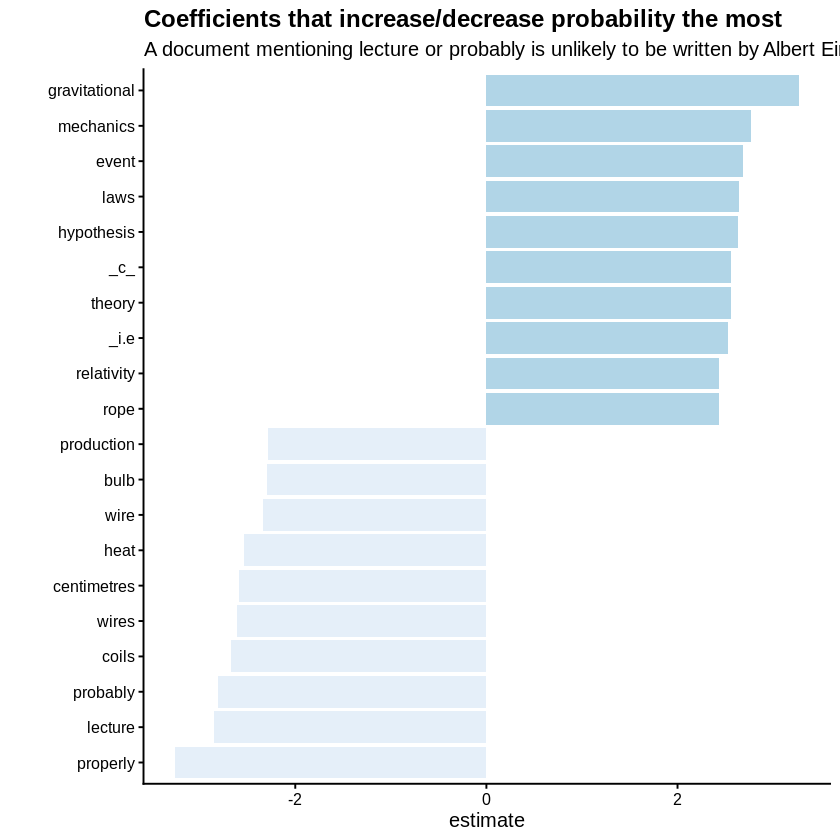

In [8]:
# ========================================================
# Step 5-2: Visualize the important feature for classification
# ========================================================

install.packages("broom") # provides functions for tidying model outputs, such as coefficients

library(broom)

coefs <-  tidy(model$glmnet.fit)  %>%
          filter(lambda == model$lambda.1se) # filters the rows where the lambda value is equal to the optimal lambda determined by cross-validation

coefs %>%
  group_by(estimate > 0) %>% # group the coefficients into two categories based on whether the estimate is greater than 0 (increasing probability) or not
  top_n(10, abs(estimate)) %>% # select the top 10 coefficients with the largest absolute estimates within each group
  ungroup() %>%
  ggplot(aes(fct_reorder(term, estimate), estimate, fill = estimate > 0)) +
  geom_col(alpha = 0.8, show.legend = FALSE) +
  coord_flip() +
  labs(
    x = NULL,
    title = "Coefficients that increase/decrease probability the most",
    subtitle = "A document mentioning lecture or probably is unlikely to be written by Albert Einstein"
  ) +
  theme_classic(base_size = 12) +
  theme(plot.title = element_text(lineheight=.8, face="bold")) +
  scale_fill_brewer()

### 3.6 Prediction on the Test Data

In [9]:
# ========================================================
# Step 6: Get the probability for the specified class on the test data set
# ========================================================

#  pull(.data, var, name = NULL)
#   Function       : Extracts a single column from a data frame or tibble as a
#                    vector. Commonly used at the end of tidyverse pipelines to
#                    convert a tibble column into a simple atomic vector.
#
#   .data          : A data frame or tibble from which the column will be extracted.
#
#   var            : The column to extract.
#                    - Can be specified by name (e.g., estimate) or by position (e.g., 2).
#                    - Quotation marks are optional for syntactic names.
#
#   name           : (Optional) A column whose values will be used to name
#                    elements of the returned vector.
#
#   Returns        : A vector containing the values from the specified column.
#                    The vector inherits the data type of that column
#                    (numeric, character, factor, logical, etc.).
#--------------------------------------------------------------------------------
#   pull(df, estimate)
#
#   Description     : Extracts the column `estimate` from tibble `df` and returns
#                     it as a simple vector (removing tibble structure and metadata).
#                     This is useful for downstream computations that require
#                     vectors, such as modeling functions or summary calculations.
#
#   var = estimate  : Specifies the column to be extracted.
#                     If the data frame `df` has a column named `estimate`,
#                     the command returns a vector of its values.
#
#   name = id       : (Optional) If provided, the resulting vector will use
#                     values from the `id` column as element names.




intercept <- coefs %>%
              filter(term == "(Intercept)") %>%
              pull(estimate)

#  plogis(intercept + score)
#   intercept      : The constant term from the fitted logistic regression model.
#   score          : The linear predictor or model score (sum of weighted feature values).
#   Function       : Applies the logistic (sigmoid) transformation to convert log-odds into probability.
#   Returns        : A numeric value between 0 and 1 representing the predicted probability of the event.
#   Output         : Transforms the linear model output (intercept + score) into a probability scale for interpretation.


# classification results on the test data
classifications <- tidy_books %>%
                    inner_join(test_data) %>%
                    inner_join(coefs, by = c("word" = "term")) %>%
                    group_by(document) %>%
                    summarize(score = sum(estimate)) %>%
                    mutate(probability = plogis(intercept + score))

head(classifications)

Joining with `by = join_by(document)`


document,score,probability
<int>,<dbl>,<dbl>
8,0.38552623,0.6090033
17,4.99612491,0.9936550
27,-0.08498412,0.4931540
39,5.78158189,0.9970972
44,5.19386233,0.9947875
62,7.90079659,0.9996504


### 3.7. Model Performance Evaluation

Several model performance metrics could be used, starting from introducing the confusion matrix.


1. **Confusion matrix**. Let’s make the following definitions that “Einstein, Albert” is treated as a positive class and “Tesla, Nikola” is viewed as  a negative class. So we can summarize our “einstein-text-prediction” model using a 2x2 confusion matrix that depicts all four possible outcomes:

    * **True Positive** (TP): The text is actually written by Einstein, and the model correctly predicts it as being from Einstein.

    * **False Positive** (FP): The text is actually written by Tesla, but the model incorrectly predicts it as being from Einstein.

    * **False Negative** (FN): The text is actually written by Einstein, but the model incorrectly predicts it as being from Tesla.

    * **True Negative** (TN): The text is actually written by Tesla, and the model correctly predicts it as being from Tesla.


2. A true positive is an outcome where the model correctly predicts the positive class (Einstein). Similarly, a true negative is an outcome where the model correctly predicts the negative class (Tesla).

3. A false positive is an outcome where the model incorrectly predicts the positive class. And a false negative is an outcome where the model incorrectly predicts the negative class.

4. Let’s use a probability of **0.5** as our threshold. That means all model predictions with a probability greater than 50% get labeld as beeing text from Einstein.

5. The ``yardstick`` package (yardstick is a package to estimate how well models are working using tidy data principles) is required to calculate some model performance metrics.

In [10]:
# ========================================================
# Step 7-1: yardstick package
# helps with performance measurement and evaluation of models, particularly for supervised learning
# ========================================================

install.packages("yardstick")
library(yardstick)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘sparsevctrs’, ‘hardhat’



Attaching package: ‘yardstick’


The following object is masked from ‘package:readr’:

    spec




In [11]:
# ========================================================
# Step 7-2: Confusion matrix
# ========================================================


comment_classes <- classifications %>%
                    left_join(books %>%
                    select(author, document), by = "document") %>%
                    mutate(author = as.factor(author))

#  conf_mat(truth, estimate)
#   truth          : The column containing the actual (true) class labels (e.g., `author`).
#   estimate       : The column containing the predicted class labels from the model (e.g., `prediction`).
#   Function       : Computes a confusion matrix that cross-tabulates actual vs. predicted classifications.
#   Returns        : A tibble displaying counts of correct and incorrect predictions for each class.
#   Output         : Provides a summary table used to assess classification model performance
#                    (e.g., accuracy, sensitivity, specificity, precision, recall).

# add the prediction label and generate confusion matrix
comment_classes %>%
  mutate(prediction = case_when(probability > 0.5 ~ "Einstein, Albert",
                                TRUE ~ "Tesla, Nikola"),
         prediction = as.factor(prediction)) %>%
         conf_mat(author, prediction)



                  Truth
Prediction         Einstein, Albert Tesla, Nikola
  Einstein, Albert              622            59
  Tesla, Nikola                  58           820

Let’s take a closer look at these misclassifications: false negatives (FN) and false positives (FP)

Which documents here were incorrectly predicted to be written by Albert Einstein, at the extreme probability end of greater than 80% (false positive)?

In [12]:
# ========================================================
# Step 7-3: Classificataion Results - FP
# ========================================================

# filter for False Positives (FP) by selecting documents where the model predicted
# "Tesla, Nikola" with a high probability (> 0.8) but the actual author is "Tesla, Nikola"

FP <- comment_classes %>%
      filter(probability > .8,
              author == "Tesla, Nikola") %>%
      # sample_n(10) %>%
      inner_join(books %>%
      select(document, text)) %>%
      select(probability, text)

dim(FP)
head(FP,n=20)

Joining with `by = join_by(document)`


[1] 3 2

probability,text
<dbl>,<chr>
0.9110139,"this allowing of turning them successively into different positions,"
0.8161715,"Leaving practicability out of consideration, this, then, would be the"
0.8236349,"In this manner an intensely phosphorescent, sharply defined line, _l_,"


These documents were incorrectly predicted to be written by Albert Einstein. However, they were written by Nikola Tesla.

Finally, let’s take a look at the texts which are from Albert Einstein that the model did not correctly identify (false negative):

In [13]:
# ========================================================
# Step 7-4: Classificataion Results - FN
# ========================================================

# filter for False Negatives (FN) by selecting documents where the model predicted "Tesla, Nikola"
# with a low probability (< 0.3) but the actual author is "Einstein, Albert"

FN <- comment_classes %>%
  filter(probability < .3,
         author == "Einstein, Albert") %>%
  # sample_n(10) %>%
  inner_join(books %>%
  select(document, text)) %>%
  select(probability, text)

dim(FN)
head(FN,n=20)

Joining with `by = join_by(document)`


[1] 23  2

probability,text
<dbl>,<chr>
0.16902208,wanderer who was unable to see the forest for the trees. May the book
0.04748467,"throwing it. Then, disregarding the influence of the air resistance, I"
0.11663541,"through the air in such a manner that its motion, as observed from the"
0.18866839,"direction, but that it would still be uniform and in a straight line."
0.18586660,"with such exactness in one domain of phenomena, and yet should be"
0.26327249,"invalid for another, is _a priori_ not very probable."
0.22113572,and in the direction indicated in Fig 1. People travelling in this
0.13520961,"be arbitrary, although it was always tacitly made even before the"
0.25492283,arises as to which of these two theorems is the better in accord with


We can conclude that the model did a very good job in predicting the authors of the texts. Furthermore, the texts of the misclassifications are quite short and we can imagine, that even a human reader who is familiar with the work of Einstein and Tesla would have difficulties to classify them correctly

Since the **confusion matrix** depends on the predefined classification threshold, we can instead use the **ROC curve** to evaluate the model’s performance independently of any specific threshold.

**ROC curve:** (receiver operating characteristic curve - a graph showing the performance of a classification model at all classification thresholds) look like:

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


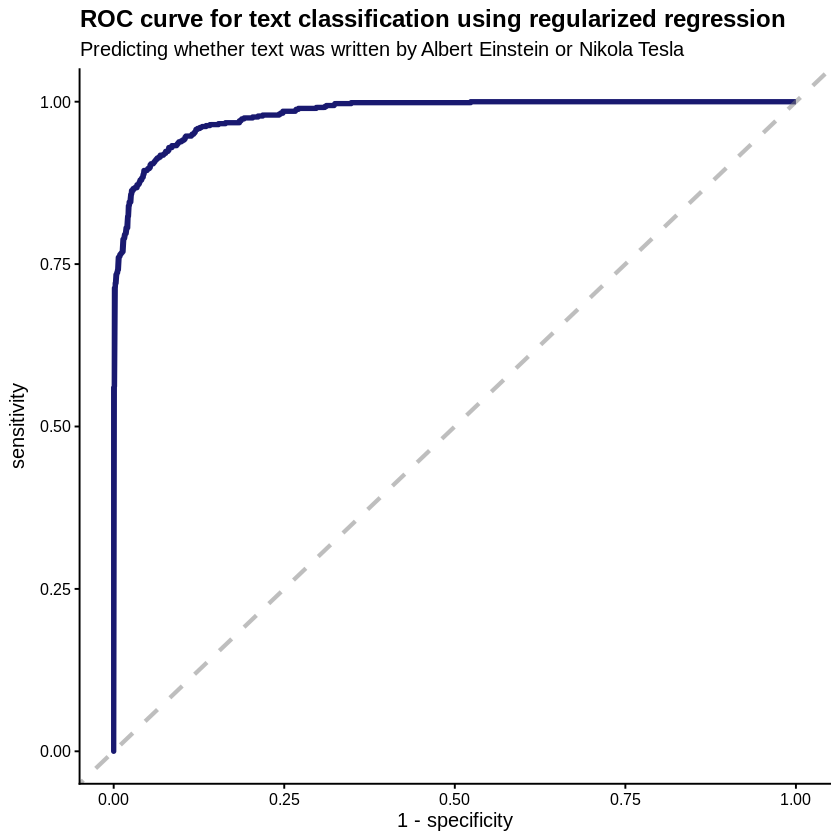

In [14]:
# ========================================================
# Step 8-1: Evluation using ROC
# ========================================================

comment_classes %>% roc_curve(author, probability) %>%
                    ggplot(aes(x = 1 - specificity, y = sensitivity)) +
                        geom_line(
                          color = "midnightblue",
                          size = 1.5 ) +
                        geom_abline(
                          lty = 2, alpha = 0.5,
                          color = "gray50",
                          size = 1.2 ) +
                        labs(
                          title = "ROC curve for text classification using regularized regression",
                          subtitle = "Predicting whether text was written by Albert Einstein or Nikola Tesla" ) +
                        theme_classic(base_size = 12) +
                        theme(plot.title = element_text(lineheight=.8, face="bold"))

Let’s obtain the accuracy (AUC - the fraction of predictions that a classification model got right) on the test data:

In [15]:
# ========================================================
# Step 8-2: AUC
# ========================================================

auc <- comment_classes %>%
  roc_auc(author, probability)

auc

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.9813023


## [4. Introduction to Support Vector Machine](#pract2)

This section utilizes the ``sunnyData.csv``. There are two columns, a text column (Text) and a label column (IsSunny).

 In this SVM classification task, we aim to use textual features to predict the next word.

**SVM General Workflow:**

 1. Load required packages e1071 (for SVM), tm (for text processing), caret (for data splitting and evaluation)
 2. Import dataset
 3. Create a text corpus. SVMs (and all machine learning models) can’t understand raw text — they only work with numbers.
 4. Preprocess the text, convert to lowercase, remove punctuation, numbers, and stop words, strip extra whitespace, and etc
 5. Create a Document-Term Matrix (DTM) (convert text into numeric features) for model training and evaluation.
 6. Add target labels. Append your class label column and convert it to a factor.
 7. Split into training and testing sets.
 8. Model training, testing, evaluation.


In [24]:
# ========================================================
# Step 1: Load the packages
# ========================================================

install.packages("RTextTools") # for text classification and analysis using machine learning techniques (SVM, MaxEnt, Random Forest, and others)
library(RTextTools)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



### 4.1 Load and preprocess data

In [53]:
# ========================================================
# Step 2: Load the data
# ========================================================

data <- read.csv("/content/sunnyData.csv", header = TRUE)

head(data, 20)

,Text,IsSunny
,<chr>,<int>
1,sunny,1
2,rainy,-1
3,sunny sunny,1
4,sunny rainy,-1
5,rainy sunny,-1
6,rainy rainy,-1
7,sunny sunny sunny,1
8,sunny rainy sunny,1
9,sunny sunny rainy,1


Note, for the classification label, we use 1 for Sunny and -1 otherwise.

In [19]:
# ========================================================
# Step 3: Preprocess the data: create the DTM format
# ========================================================

# Create the document term matrix
dtMatrix <- create_matrix(data["Text"])
head(dtMatrix)

Warning message in TermDocumentMatrix.SimpleCorpus(x, control):
“custom functions are ignored”
Warning message in TermDocumentMatrix.SimpleCorpus(x, control):
“custom tokenizer is ignored”


<<DocumentTermMatrix (documents: 6, terms: 2)>>
Non-/sparse entries: 8/4
Sparsity           : 33%
Maximal term length: 5
Weighting          : term frequency (tf)

### 4.2 Create and train the SVM model:

In order to train a SVM model with RTextTools, we need to put the document term matrix inside a container.

 * When you use Support Vector Machines (SVM) or other machine learning models in RTextTools, you need to supply your data and labels in a consistent, structured format.

 * In the container's configuration, we indicate that the whole data set will be the training set.

In [20]:
# ========================================================
# Step 4: Train-Test splitting
# ========================================================

# create_container(matrix, labels = NULL, trainSize = NULL, testSize = NULL, virgin = TRUE)
#   Function        : Creates a **classification container** object for text analytics
#                     using the **RTextTools** package.
#                     It organizes a document-term matrix (DTM) along with associated
#                     class labels into training and testing partitions, preparing the data
#                     for supervised machine learning algorithms (e.g., SVM, MAXENT, RF).
#
#   matrix          : A DocumentTermMatrix or TermDocumentMatrix — the numeric/text matrix
#                     representing document-term frequencies or weights (e.g., from `tm` or `text2vec`).
#
#   labels          : A factor or character vector containing the class labels (dependent variable)
#                     for each document in the DTM.
#
#   trainSize       : Numeric vector specifying which rows (documents) of the DTM
#                     should be used for training. The rest can be used for testing.
#
#   testSize        : (Optional) Numeric vector specifying which rows should be used
#                     for testing. If omitted, all remaining documents are assigned to testing.
#
#   virgin          : Logical; if `FALSE`, the function assumes both training and test sets
#                     are from the same labeled dataset.
#                     If `TRUE`, indicates that the test set contains unlabeled data (e.g., new text to predict).
#
#   Returns         : A **container object** (of class `"RTextTools_container"`) containing:
#                       - Training and test matrices
#                       - Corresponding labels (if provided)
#                       - Indices for training/testing sets
#                     This container is used as input to modeling functions such as
#                     `train_model()` or `classify_model()`.
#--------------------------------------------------------------------------------
#   create_container(dtMatrix, data$IsSunny, trainSize = 1:11, virgin = FALSE) :
#                     Creates a classification container from the document-term matrix `dtMatrix`,
#                     associating each document with the label vector `data$IsSunny`.
#
#   dtMatrix         : The DocumentTermMatrix representing text features.
#   data$IsSunny     : A vector of labels indicating whether each observation corresponds
#                      to “sunny” or “not sunny” conditions.
#   trainSize = 1:11  : Uses documents 1 through 11 as the **training set**.
#   virgin = FALSE    : Indicates that both training and test sets are labeled —
#                      enabling supervised training and evaluation.
#
#   Returns           : A container object that links the text data in `dtMatrix`
#                       with its associated weather classification labels (`IsSunny`),
#                       ready for model training with `train_model()`.


container <- create_container(dtMatrix, data$IsSunny, trainSize = 1:11, virgin = FALSE) # Compare with Step 3.2. Does this partition look good?

# train_model(container, algorithm, ...)
#   Function        : Trains a **supervised machine learning model** using the data
#                     stored in an RTextTools container.
#                     It supports multiple algorithms such as SVM, MAXENT, GLMNET,
#                     Random Forest, and others, allowing classification of text data.
#
#   container       : An object created by `create_container()` that contains the
#                     document-term matrix, labels, and training/test indices.
#
#   algorithm       : A character string specifying which algorithm to use for training.
#                     Common options include:
#                       - `"SVM"`        → Support Vector Machine (via e1071 package)
#                       - `"MAXENT"`     → Maximum Entropy classifier
#                       - `"GLMNET"`     → Regularized logistic regression
#                       - `"RF"`         → Random Forest classifier
#                       - `"TREE"`       → Decision tree
#                       - `"BAGGING"`    → Bagged tree models
#
#   kernel          : (Optional, for SVM) Specifies the type of kernel function used:
#                       - `"linear"` (default) → linear hyperplane
#                       - `"polynomial"`       → nonlinear, polynomial decision boundaries
#                       - `"radial"`           → radial basis function (RBF kernel)
#                       - `"sigmoid"`          → hyperbolic tangent kernel
#
#   cost            : (Optional, for SVM) The cost (C) parameter that controls the
#                     trade-off between maximizing the margin and minimizing
#                     classification errors.
#                     Higher values penalize misclassification more heavily.
#
#   ...             : Additional parameters passed to the underlying learning algorithm.
#
#   Returns         : A trained model object of class `"RTextTools_model"`,
#                     containing:
#                       - The fitted algorithm (e.g., SVM model)
#                       - Model parameters and diagnostics
#                       - The associated container and training metadata
#--------------------------------------------------------------------------------
#   train_model(container, "SVM", kernel = "linear", cost = 1) :
#                     Trains a **Support Vector Machine (SVM)** classifier using
#                     the training data defined in the `container` object.
#
#   container        : The training data structure created earlier via `create_container()`,
#                      linking the document-term matrix (`dtMatrix`) and labels (`IsSunny`).
#
#   "SVM"            : Specifies that the algorithm used for training is
#                      a Support Vector Machine.
#
#   kernel = "linear": Requests a **linear kernel**, meaning the model separates
#                      classes with a straight hyperplane — suitable when data
#                      are linearly separable or approximately so.
#
#   cost = 1         : Sets the regularization parameter (C) to 1, providing a
#                      balanced trade-off between maximizing the margin and
#                      minimizing misclassification.
#
#   Returns          : A trained SVM model that has learned to distinguish between
#                      classes (e.g., “Sunny” vs “Not Sunny”) based on the text features
#                      in the document-term matrix.
#                      This model can later be applied to new/unseen text data
#                      using `classify_model()`.


model <- train_model(container, "SVM", kernel = "linear", cost = 1)

### 4.3 Predict with new data

Now that our model is trained, we can use it to make new predictions! We will create new sentences which were not in the training data.

Let's assume we are predict with new data:

- "sunny sunny sunny rainy rainy"
    * This sentence talks more about the sunny weather than the rainy. We expect it to be classified as sunny (+1)
- "rainy sunny rainy rainy"
    * This sentence talks more about the rainy weather than the sunny. We expect it to be classified as rainy (-1)
- ""
    * This sentence has no word, it should return either +1 or -1 in function of the decision boundary
- "hello"
    * This sentence has a word which was not present in the training set. It will be equivalent to ""
- "this is another rainy world"
    * This sentence has several worlds not in the training set, and the word rainy. It is equivalent to the sentence "rainy" and should be classified "-1"

In [21]:
# ========================================================
# Step 5: Predict with data
# ========================================================

predictionData <- list("sunny sunny sunny rainy rainy", "rainy sunny rainy rainy", "hello", "", "this is another rainy world")

predMatrix <- create_matrix(predictionData, originalMatrix=dtMatrix)

Warning message in TermDocumentMatrix.SimpleCorpus(x, control):
“custom functions are ignored”
Warning message in TermDocumentMatrix.SimpleCorpus(x, control):
“custom tokenizer is ignored”


Notice that this time we provided the originalMatrix as a parameter. This is because **we want the new matrix to use the same vocabulary as the training matrix**

  * Without this indication, the function will create a document term matrix using all the words of the test data (rainy, sunny, hello, this, is, another, world). It means that each sentence will be represented by a vector containing 7 values (one for each word) !

  * Such a matrix won't be compatible with the model we trained earlier because it expect vectors containing 2 values (one for rainy, one for sunny).

We now create the container.

In [52]:
# ========================================================
# Step 6: Create the corresponding container
# ========================================================


predSize = length(predictionData);

# rep(x, times)
#   Function        : Creates a vector by **repeating values** a specified number of times.
#                     It is a base R function used to efficiently generate repeated data patterns.
#
#   x               : The value or vector to be repeated (numeric, character, logical, etc.).
#
#   times           : Integer indicating how many times each element of `x` should be repeated.
#                     Can be a single number or a vector of repetition counts.
#
#   Returns         : A vector containing the repeated sequence of elements from `x`.
#                     The output type matches that of the input (e.g., numeric, character).
#--------------------------------------------------------------------------------
#   rep(0, predSize) :
#                     Creates a numeric vector consisting of zeros, repeated
#                     `predSize` times.
#
#   0                : The value to be repeated.
#   predSize         : A variable specifying how many times 0 should be repeated.
#                      Typically represents the number of prediction or test cases.
#
#   Returns          : A numeric vector like:
#                        c(0, 0, 0, 0, ..., 0)
#                      of length equal to `predSize`.
#
#   Example:
#       If predSize = 5 → rep(0, predSize)
#       returns: c(0, 0, 0, 0, 0)
#
#   Use case:
#       Commonly used for initializing placeholder vectors — for instance,
#       to store predicted values or results before populating them in a loop.

predictionContainer <- create_container(predMatrix, labels = rep(0,predSize),
                                        testSize = 1:predSize, virgin=FALSE)


Two things are different:

- we use a zero vector for labels, because we want to predict them
- we specified **testSize** instead of **trainingSize** so that the data will be used for testing

Eventually, we can make predictions:

In [23]:
# ========================================================
# Step 7: Predict
# ========================================================

# classify_model(container, model)
#   Function        : Applies a **trained machine learning model** (e.g., SVM, MAXENT, RF)
#                     to classify or predict the labels of new or test documents.
#                     It is part of the **RTextTools** package and works on the
#                     container object that holds test data and metadata.
#
#   container       : An object created by `create_container()` that contains:
#                       - The **test matrix** (document-term representation of unseen data)
#                       - Indices of test cases
#                       - (Optionally) known labels for evaluation
#
#   model           : A trained model object returned by `train_model()`.
#                     This model could be of type SVM, MAXENT, GLMNET, RF, etc.,
#                     depending on the algorithm used during training.
#
#   Returns         : A data frame containing the classification results, typically with:
#                       - `SCORE1`, `SCORE2`, ... → Model confidence/probability scores
#                       - `PREDICTED_LABEL`       → The predicted class for each document
#                     The structure of the output depends on the algorithm used.
#--------------------------------------------------------------------------------
#   classify_model(predictionContainer, model) :
#                     Uses a **trained classifier** (stored in `model`) to make predictions
#                     on new or test data contained in `predictionContainer`.
#
#   predictionContainer : A container created using `create_container()` that holds
#                         the **prediction matrix** (from `create_matrix(predictionData, originalMatrix = dtMatrix)`).
#
#   model                : The previously trained model, such as the SVM created with
#                          `train_model(container, "SVM", kernel = "linear", cost = 1)`.
#
#   Returns              : A data frame where each row corresponds to a test or new document,
#                          containing predicted class labels and associated probabilities.
#
#   Example usage:
#       preds <- classify_model(predictionContainer, model)
#       head(preds)
#           → Shows predicted categories (e.g., "Sunny" / "Not Sunny") for new text data.
#
#   Use case:
#       This function is the final step in the **RTextTools text classification pipeline**,
#       applying the trained model to unseen data for evaluation or real-world prediction.

results <- classify_model(predictionContainer, model)
results

,SVM_LABEL,SVM_PROB
,<chr>,<dbl>
1,1,0.7931699
2,-1,0.9244283
3,1,0.5153440
4,1,0.5153440
5,-1,0.7723010


As expected the first sentence has been classified as sunny and the second and last one as rainy.

We can also see that the third and fourth sentences  ("hello" and "") have been classified as rainy, but the probability is only  52% which means our model is not very confident on these two predictions.

## [5. Introduction to Naive Bayes](#pract3)

For this section, Naive Bayes, we use the Dataset which is a subset of RCV1 (Lewis, Yang, Rose, & and Li, 2004), a text categorization test collection dataset developed by ZhiLiu and was donated on September 08, 2011 (ZhiLiu, 2011). The dataset is composed of Top 50 Authors and Top 100 texts of the Authors and Testing Data. So, a data with 5000 instances and is divided into 2 parts: Training and Testing. The training corpus consists of 2,500 texts (50 per author) and the test corpus includes other 2,500 texts (50 per author) non-overlapping with the training texts (ZhiLiu, 2011).

**Attributes Information:**

  * The dataset contains two attributes: author name and text. The author name contains 50 attribute specifies the text written by them. The text attribute contains the unprocessed text. The dataset consists total of 5000 instances.

**Naive Bayes General Workflow:**
 1. Load required packages e1071 (for Naive Bayes model), tm (for text processing)
 2. Import dataset
 3. Create a text corpus. Naive Bayes (and all machine learning models) can’t understand raw text — they only work with numbers.
 4. Preprocess the text, convert to lowercase, remove punctuation, numbers, and stop words, strip extra whitespace, and etc
 5. Create a Document-Term Matrix (DTM) (convert text into numeric features) for model training and evaluation.
 6. Add target labels. Append your class label column and convert it to a factor.
 7. Split into training and testing sets.
 8. Model training, testing, evaluation.



### 5.1 Load and preprocess data

In [26]:
# ========================================================
# Step 1: Load the library (through system command)
# ========================================================

system("apt-get update")
system("apt-get install -y libpoppler-cpp-dev")

install.packages("pdftools")   # Installs tools to extract and process text from PDF files.
install.packages("readtext")   # Installs functions to read text data from various formats (txt, csv, pdf, etc.) into R.
install.packages("data.table") # Installs a high-performance package for fast data manipulation and aggregation.
install.packages("tm")         # Installs the Text Mining package for text preprocessing and corpus management.

install.packages("wordcloud")

library(readtext)
library(data.table)
library(tm)
library(wordcloud)

In [55]:
# ========================================================
# Step 2: Download Dataset (train, test)
# ========================================================

if(!file.exists("reuter+50+50.zip")){
        #Downloading File
        download.file(url = "https://archive.ics.uci.edu/static/public/217/reuter+50+50.zip",
                      destfile = "/content/reuter+50+50.zip")

        #Unzipping the File
        unzip("/content/reuter+50+50.zip", exdir = "/content/reuter+50+50/")
}


# retrieve the training data
data_train_dir <- system.file("/content/reuter+50+50/C50train")

# readtext(filepaths, text_field = NULL, encoding = NULL, dvsep = NULL, ...)
#   Function        : Imports and reads a collection of text files into a data frame-like
#                     structure.
#                     The **readtext** package is designed for easily loading large sets
#                     of text documents (from .txt, .csv, .json, etc.) along with optional
#                     metadata for text mining or NLP tasks.
#
#   filepaths       : A character vector specifying one or more paths to text files.
#                     Wildcards (e.g., `*`) can be used to read multiple files in a directory.
#                     Example: `"data/*.txt"` reads all `.txt` files in the `data` folder.
#
#   text_field      : (Optional) For structured files (like .csv or .json), specifies
#                     which field/column contains the text to read. Not required for plain `.txt` files.
#
#   encoding        : (Optional) Character string giving the file encoding (e.g., `"UTF-8"`).
#                     If omitted, encoding is guessed automatically.
#
#   dvsep           : (Optional) “Document variable separator.”
#                     Defines how metadata variables (document names, categories, etc.)
#                     are separated from the text.
#                     Commonly used when file contents or filenames include metadata.
#                     For plain text files, it is often left `NULL` or set to a newline character (`"\n"`).
#
#   ...             : Additional arguments passed to underlying read functions.
#
#   Returns         : A **data frame-like object** (class `"readtext"`) with columns:
#                       - `doc_id` → Document identifier (often filename)
#                       - `text`   → The full text of the document
#                       - Additional columns for metadata if available
#--------------------------------------------------------------------------------
#   readtext("/content/reuter+50+50/C50train/*", dvsep = "\n") :
#                     Reads **all text files** located in the folder
#                     `/content/reuter+50+50/C50train/`, treating each file as
#                     a separate document.
#
#   "/content/reuter+50+50/C50train/*" :
#                     The wildcard `*` means “read every file” inside the directory.
#                     This is typical for corpus datasets like the Reuters-50-50 text corpus.
#
#   dvsep = "\n"     : Specifies that document variables (if any) are separated by
#                      newline characters. In most plain-text cases, this simply
#                      ensures clean separation of document text.
#
#   Returns           : A `readtext` object containing one row per document, where:
#                         - `doc_id` identifies each file
#                         - `text` holds the file’s content


Data_train <- readtext("/content/reuter+50+50/C50train/*", dvsep = "\n")

head(Data_train$text, n = 1)


# retrieve the testing data
data_test_dir <- system.file("/content/reuter+50+50/C50test")
Data_test <- readtext("/content/reuter+50+50/C50test/*", dvsep = "\n")

[1] "The Internet may be overflowing with new technology but crime in cyberspace is still of the old-fashioned variety.\nThe National Consumers League said Wednesday that the most popular scam on the Internet was the pyramid scheme, in which early investors in a bogus fund are paid off with deposits of later investors.\nThe league, a non-profit consumer advocacy group, tracks web scams through a site it set up on the world wide web in February called Internet Fraud Watch at http://www.fraud.org.\nThe site, which collects reports directly from consumers, has been widely praised by law enforcement agencies.\n\"Consumers who suspect a scam on the Internet have critical information,\" said Jodie Bernstein, director of the Federal Trade Commission's Bureau of Consumer Protection. Internet Fraud Watch \"has been a major help to the FTC in identifying particular scams in their infancy.\"\nIn May, for example, the commission used Internet reports to shut down a site run by Fortuna Alliance that had taken in over $6 million, promising investors they could earn $5,000 a month from an initial deposit of $250. Instead, Fortuna kept most of the money, the commission charged.\nFraud reports from the league's site, which has been visited over 370,000 times, are forwarded to local, state and federal authorities.\nThe second-most-popular Internet scam, the league said, was the sale of bogus Internet services, such as custom designed web sites or Internet access accounts.\nIn third place were crooks who sell computer equipment, such as memory chips or sound boards, over the net and then deliver significantly lower quality goods or nothing at all, the league said.\nOther top scams involve business opportunities. Con artists may offer shares in a business or franchise using unreasonable predictions or misrepresentations. One popular scheme promised to let consumers get rich while working at home.\nThe League also announced Tuesday that NationsBank had donated $100,000 to become a sponsor of the Fraud Watch site."

In [65]:
# ========================================================
# Step 3: Preparing training and testing set
# ========================================================

#Author Names
Authornames <- as.data.frame(rep(basename(list.dirs("/content/reuter+50+50/C50train")), each = 50))
Authornames <- Authornames[-(1:50),]

#Assigning Author name to Text
Data_test$Author <- Authornames
Data_train$Author <- Authornames

#Dropping ID Column
Data_test <- Data_test[-1]
Data_train <- Data_train[-1]

#Converting Author Column to Factor
Data_test$Author <- as.factor(Data_test$Author)
Data_train$Author <- as.factor(Data_train$Author)

AaronTrain <- Data_train %>% filter(Author == "AaronPressman", text == text)
JaneTrain <- Data_train %>% filter(Author == "JaneMacartney", text == text)
SarahTrain <- Data_train %>% filter(Author == "SarahDavison", text == text)
WilliamTrain <- Data_train %>% filter(Author == "WilliamKazer", text == text)
Data_train <- rbind(AaronTrain, JaneTrain, SarahTrain, WilliamTrain)

AaronTest <- Data_test %>% filter(Author == "AaronPressman", text == text)
JaneTest <- Data_test %>% filter(Author == "JaneMacartney", text == text)
SarahTest <- Data_test %>% filter(Author == "SarahDavison", text == text)
WilliamTest <- Data_test %>% filter(Author == "WilliamKazer", text == text)
Data_test <- rbind(AaronTest, JaneTest, SarahTest, WilliamTest)

dim(Data_train)
dim(Data_test)
table(Data_train$Author)

[1] 200   2

[1] 200   2


    AaronPressman        AlanCrosby    AlexanderSmith   BenjaminKangLim 
               50                 0                 0                 0 
    BernardHickey       BradDorfman  DarrenSchuettler       DavidLawder 
                0                 0                 0                 0 
    EdnaFernandes       EricAuchard    FumikoFujisaki    GrahamEarnshaw 
                0                 0                 0                 0 
 HeatherScoffield     JaneMacartney        JanLopatka      JimGilchrist 
                0                50                 0                 0 
         JoeOrtiz      JohnMastrini      JonathanBirt    JoWinterbottom 
                0                 0                 0                 0 
      KarlPenhaul         KeithWeir    KevinDrawbaugh     KevinMorrison 
                0                 0                 0                 0 
    KirstinRidley KouroshKarimkhany         LydiaZajc    LynneO'Donnell 
                0                 0               

In [66]:
# ========================================================
# Step 4: Exploring data
# ========================================================

# Checking for missing values
any(is.na(Data_train))
any(is.na(Data_test))

# you can add more codes to explore data

[1] FALSE

[1] FALSE

To analyze the textdata, the first step involves creating a corpus, which refers to a collection of text documents. The Corpus was created from the dataset using Corpus() function of “tm” package of R. It creates the R object to store text documents

The Corpus data was then cleaned using “tm_map()” function. For cleaning the corpus, the text was converted to lower case using “tolower” attribute of tm_map. Then using “removeNumbers”, “removeWords”, “stopwords()” as well as “stripWhitespace” functions, the number, stopping words and white spaces were removed. The figure shows the clean corpus element 1 of Training Dataset

In [67]:
# ========================================================
# Step 5: Create a text corpus
# ========================================================


# you can add suppressWarnings() to suppressWarnings

# VectorSource(x)
#   Function        : Creates a **text source** object from a character vector,
#                     typically used as input to the **tm** package’s `Corpus()` function.
#                     A VectorSource treats each element of the vector as one text document.
#
#   x               : A character vector where each element represents one document
#                     (e.g., rows of text data, sentences, or articles).
#
#   Returns         : An object of class `"VectorSource"` — a simple source that allows
#                     R’s text-mining functions (like `Corpus()`) to read text data
#                     directly from memory instead of files.
#--------------------------------------------------------------------------------
#   VectorSource(Data_test$text) :
#                     Converts the column `Data_test$text` — which contains multiple
#                     text entries — into a VectorSource object.
#                     This prepares the text for corpus creation and further preprocessing.
#
#   Data_test$text   : A character vector extracted from a data frame (`Data_test`),
#                      where each element represents a separate document (e.g., one review,
#                      article, or message).

suppressWarnings(Data_test_corpus <- Corpus(VectorSource(Data_test$text)))
suppressWarnings(Data_train_corpus <- Corpus(VectorSource(Data_train$text)))


# tm_map(x, FUN, ...)
# content_transformer(FUN)
#   Function        : Applies a sequence of **text preprocessing transformations**
#                     to a corpus of text documents. These functions are part of the
#                     **tm** package and are typically used to clean and normalize text
#                     before analysis, tokenization, or model training.
#
#   tm_map(x, FUN, ...) :
#                     Applies a specified function (`FUN`) to every document in the corpus `x`.
#
#   content_transformer(FUN) :
#                     Wraps a base R function (like `tolower` or `gsub`) so that it can be
#                     safely applied to the text content of each document in a corpus.
#
#   Returns         : A transformed `Corpus` object after applying each function in sequence.
#--------------------------------------------------------------------------------
#   tm_map(content_transformer(tolower))
#       → Converts all text to lowercase.
#         Ensures words like “Sunny” and “sunny” are treated identically.
#
#   tm_map(removeNumbers)
#       → Removes all numeric digits from the text.
#         Useful when numbers are not semantically meaningful (e.g., “2024”, “100%”).
#
#   tm_map(removeWords, stopwords("english"))
#       → Removes common English stopwords (e.g., "the", "and", "of", "to").
#         This helps focus on meaningful content words that carry semantic value.
#
#   tm_map(removePunctuation)
#       → Strips punctuation marks (e.g., ".", ",", "?", "!") from the text.
#         Prevents punctuation from being treated as tokens or words in analysis.
#
#   tm_map(stripWhitespace)
#       → Removes extra spaces, tabs, and newlines left behind by earlier cleaning steps.
#         Ensures consistent spacing and tidy text.

#Corpus Cleaning
Data_test_corpus_clean <- suppressWarnings(Data_test_corpus %>%
                                            tm_map(content_transformer(tolower)) %>%
                                            tm_map(removeNumbers) %>%
                                            tm_map(removeWords, stopwords("english")) %>%
                                            tm_map(removePunctuation) %>%
                                            tm_map(stripWhitespace))



Data_train_corpus_clean <- suppressWarnings(Data_train_corpus %>%
                                            tm_map(content_transformer(tolower)) %>%
                                            tm_map(removeNumbers) %>%
                                            tm_map(removeWords, stopwords("english")) %>%
                                            tm_map(removePunctuation) %>%
                                            tm_map(stripWhitespace))


inspect(Data_train_corpus_clean[1])



<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 1

[1]  internet may overflowing new technology crime cyberspace still oldfashioned variety national consumers league said wednesday popular scam internet pyramid scheme early investors bogus fund paid deposits later investors league nonprofit consumer advocacy group tracks web scams site set world wide web february called internet fraud watch httpwwwfraudorg site collects reports directly consumers widely praised law enforcement agencies consumers suspect scam internet critical information said jodie bernstein director federal trade commissions bureau consumer protection internet fraud watch major help ftc identifying particular scams infancy may example commission used internet reports shut site run fortuna alliance taken million promising investors earn month initial deposit instead fortuna kept money commission charged fraud reports leagues site visited times forwarded local state feder

The text from Training Dataset was split according to authors. Using the “wordcloud” package of R, the most used words by authors were visualized. The following word cloud is the visualization of most frequently used words in by author in test and training database

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: RColorBrewer



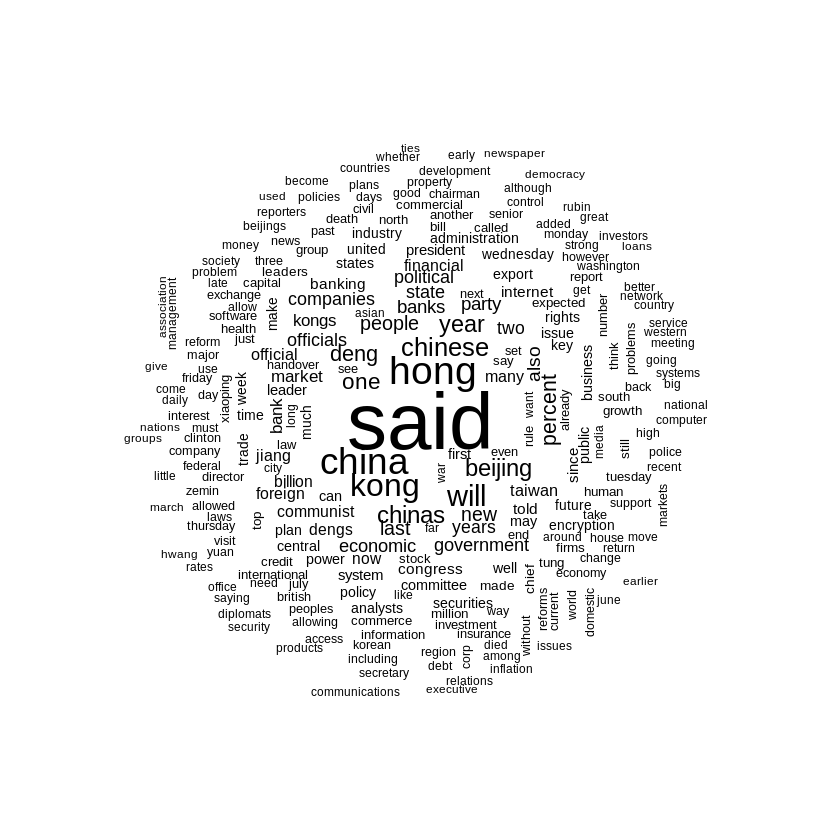

In [37]:
# ========================================================
# Step 6: Word cloud visualization
# ========================================================

wordcloud(Data_test_corpus_clean, min.freq = 40, random.order = FALSE)

The data is then split into individual components commonly known as tokenization

The token was achieved using “DocumentTermMatrix()” function of “tm” package

This will create a data structure called Sparse Matrix in which rows indicate the Text and Column represents the word.

In [68]:
# ========================================================
# Step 7: Convert to sparse matrix
# ========================================================

test_dtm <- DocumentTermMatrix(Data_test_corpus_clean)
train_dtm <- DocumentTermMatrix(Data_train_corpus_clean)

inspect(train_dtm)

<<DocumentTermMatrix (documents: 200, terms: 8765)>>
Non-/sparse entries: 41629/1711371
Sparsity           : 98%
Maximal term length: 36
Weighting          : term frequency (tf)
Sample             :
     Terms
Docs  china chinese hong kong last one percent said will year
  126     0       0    3    3    1   1       1   13    3    1
  127     4       1    2    2    3   3       7    5   11    6
  133     1       0    3    3    2   2       5    7    3    3
  137     1       6   12   11    1   5       0   12    3    3
  139     0       1    2    2    6   1      14   23    9    1
  140    17       4   27   19    1   6       3   12   15    2
  51      2       3    0    0    1   5       1   17    0    6
  53      2      14    0    0    1   4       1    6    0    2
  55      1       1    0    0    2   0       2   16    2    4
  60      3       4    0    0    2   5       4    9    0    6


To predict the model using Naive Bayes Classification, the training and testing datasets are obtained using frequency of words

In [69]:
# ========================================================
# Step 8: Preparing training and testing datasets
# ========================================================


FreqWords <- findFreqTerms(train_dtm, 5)

# Saving List using Dictionary() Function
Dictionary <- function(x) {
                            if( is.character(x) ) { return (x) }
                            stop('x is not a character vector')
                          }

data_dict <- Dictionary(findFreqTerms(train_dtm, 5))

#Appending Document Term Matrix to Train and Test Dataset
data_train <- DocumentTermMatrix(Data_train_corpus_clean, list(data_dict))
data_test <- DocumentTermMatrix(Data_test_corpus_clean, list(data_dict))

#Converting the frequency of word to count
convert_counts <- function(x) {
        x <- ifelse(x > 0, 1, 0)
        x <- factor(x, levels = c(0, 1), labels = c("No", "Yes"))
        return(x)
}

# apply(X, MARGIN, FUN, ...)
#   Function        : Applies a function (`FUN`) to the **rows** or **columns** of a matrix
#                     or data frame. It is part of base R and is commonly used for element-wise
#                     or column-wise transformations.
#
#   X               : The array, matrix, or data frame on which to apply the function.
#
#   MARGIN          : Integer indicating the dimension(s) over which to apply the function:
#                       - `1` → apply over **rows**
#                       - `2` → apply over **columns**
#                       - `c(1, 2)` → apply to **each element**
#
#   FUN             : The function to apply to each row or column (e.g., `mean`, `sum`,
#                     or a user-defined function like `convert_counts`).
#
#   ...             : Additional arguments passed to the function `FUN`.
#
#   Returns         : An array, list, or vector of results depending on the output of `FUN`.
#--------------------------------------------------------------------------------
#   apply(data_train, MARGIN = 2, convert_counts) :
#                     Applies the custom function `convert_counts` **column-wise**
#                     (since `MARGIN = 2`) to the `data_train` matrix or data frame.
#
#   data_train       : A document-term matrix (DTM) or similar numeric dataset
#                      containing term frequencies (counts of words across documents).
#
#   MARGIN = 2       : Specifies that `convert_counts` should be applied to each **column**,
#                      i.e., each term or feature across all documents.
#
#   convert_counts   : A user-defined function (commonly used in text mining) that
#                      converts raw term counts into a binary or normalized representation.
#                      For example:
#                        ```r
#                        convert_counts <- function(x) {
#                          x <- ifelse(x > 0, 1, 0)
#                          x <- factor(x, levels = c(0, 1), labels = c("No", "Yes"))
#                          return(x)
#                        }
#                        ```
#                      This transforms term counts into a categorical variable
#                      indicating whether a term is present ("Yes") or absent ("No").
#
#   Returns          : A transformed matrix where each column (term) has been
#                      converted according to the logic in `convert_counts`.
#                      This is typically used before fitting models like Naive Bayes,
#                      which require binary or categorical input.


#Appending count function to Train and Test Dataset
data_train <- apply(data_train, MARGIN = 2, convert_counts)
data_test <- apply(data_test, MARGIN = 2, convert_counts)

### 5.2 Training the model

In [40]:
# ========================================================
# Step 9: Naive Bayes Classification
# ========================================================

install.packages("e1071")
library(e1071)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘e1071’


The following object is masked from ‘package:rsample’:

    permutations


The following object is masked from ‘package:ggplot2’:

    element




In [70]:
# ========================================================
# Step 10: Train the model
# ========================================================

data_classifier <- naiveBayes(data_train, Data_train$Author)

### 5.3 Evaluating the model

In [43]:
# ========================================================
# Step 11-1: Model evalution packages
# ========================================================

install.packages("gmodels")   # Installs functions for statistical modeling, including cross-tabulations and model summaries.

library(gmodels)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gtools’, ‘gdata’




In [74]:
# ========================================================
# Step 11-2: Model evalution
# ========================================================

data_test_pred <- predict(data_classifier, data_test)

CrossTable(data_test_pred, Data_test$Author,
           prop.chisq = FALSE, prop.t = FALSE,
           dnn = c('predicted', 'actual'))

accuracy <- mean(data_test_pred == Data_test$Author)
accuracy


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  200 

 
              | actual 
    predicted | AaronPressman | JaneMacartney |  SarahDavison |  WilliamKazer |     Row Total | 
--------------|---------------|---------------|---------------|---------------|---------------|
AaronPressman |            46 |             0 |             0 |             0 |            46 | 
              |         1.000 |         0.000 |         0.000 |         0.000 |         0.230 | 
              |         0.920 |         0.000 |         0.000 |         0.000 |               | 
--------------|---------------|---------------|---------------|---------------|---------------|
JaneMacartney |             0 |            40 |             2 |            14 |            56 | 
              |         0.000 |         0.714 |         0.036 |         0.250 |         0.280 | 
 

[1] 0.83

From the results we can observe that the accuracy achieved is 83.0%.

### 5.4 Improving model performance

One potential technique for improving the performance of the Naive Bayes model is to tune the Laplace smoothing parameter: for example, by setting ``laplace = 1``.

* Without Laplace smoothing: If a new word appears in a test document that was never seen in training for a class, the model assumes that class is impossible.

* With Laplace smoothing: The model assumes unseen words are just very rare, not impossible.

This small change helps generalize better to new data and improves prediction accuracy, especially with small datasets or sparse text.

In [76]:
# ========================================================
# Step 12: Improve model
# ========================================================

data_classifier2 <- naiveBayes(data_train, Data_train$Author,laplace = 1)

data_test_pred2 <- predict(data_classifier2, data_test)

CrossTable(data_test_pred2, Data_test$Author,
           prop.chisq = FALSE, prop.t = FALSE,
           dnn = c('predicted', 'actual'))

accuracy <- mean(data_test_pred == Data_test$Author)
accuracy


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  200 

 
              | actual 
    predicted | AaronPressman | JaneMacartney |  SarahDavison |  WilliamKazer |     Row Total | 
--------------|---------------|---------------|---------------|---------------|---------------|
AaronPressman |            49 |             0 |             0 |             0 |            49 | 
              |         1.000 |         0.000 |         0.000 |         0.000 |         0.245 | 
              |         0.980 |         0.000 |         0.000 |         0.000 |               | 
--------------|---------------|---------------|---------------|---------------|---------------|
JaneMacartney |             0 |            30 |             1 |             9 |            40 | 
              |         0.000 |         0.750 |         0.025 |         0.225 |         0.200 | 
 

[1] 0.83